In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
from pandas.io.json import json_normalize
import datetime
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.SnowballStemmer('english')

In [2]:
FMlinkList = {'August':'https://www.commonsense.org/education/privacy/blog/digital-redlining-access-privacy',
        'September':'http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/',
        'October':'http://marginalsyllab.us/wp-content/uploads/2016/08/PWFlow-Intro.pdf',
        'November':'https://helenbeetham.com/2016/11/14/ed-tech-and-the-circus-of-unreason/',
        'January':'http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/',
        'February':'http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy-hicks/',
        'FebruaryJCI':'http://cognitionandinstruction.com/engagements-the-learning-sciences-in-a-new-era-of-u-s-nationalism/',
        'March':'https://www.colorlines.com/articles/how-can-white-teachers-do-better-urban-kids-color'}

In [4]:
##Create empty dataFrame, and append data scraped from annotation api
dfAllupdate = pd.DataFrame(columns=['created','document.title','group','id','links.html',
       'links.incontext','links.json','permissions.admin',
       'permissions.delete','permissions.read','permissions.update',
       'references','tags','target','text','updated','uri','user','session'])
for session,link in FMlinkList.items():
    df = scrapeAPI(session,link)
    dfAllupdate = dfAllupdate.append(df)
print('Total Records: ',len(dfAllupdate))

August
https://www.commonsense.org/education/privacy/blog/digital-redlining-access-privacy
Number of Records Found for this Session:  190
Scraped:
0
20
40
60
80
100
120
140
160
180
190
March
https://www.colorlines.com/articles/how-can-white-teachers-do-better-urban-kids-color
Number of Records Found for this Session:  29
Scraped:
0
20
29
February
http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy-hicks/
Number of Records Found for this Session:  121
Scraped:
0
20
40
60
80
100
120
121
January
http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/
Number of Records Found for this Session:  242
Scraped:
0
20
40
60
80
100
120
140
160
180
200
220
240
242
September
http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/
Number of Records Found for this Session:  87
Scraped:
0
20
40
60
80
87
November
https://helenbeetham.com/2016/11/14/ed-tech-and-the-circus-of-unreason/
Number o

In [23]:
totalvocab_stemmed = []
totalvocab_tokenized = []
textExtraction.ix[:9]['text'].map(lambda x: totalvocab_stemmed.extend(tokenize_and_stem(x)))
textExtraction.ix[:9]['text'].map(lambda x: totalvocab_tokenized.extend(tokenize_only(x)))

2017-03-07 11:48:36.789289-07:00    None
2017-03-07 11:47:15.703858-07:00    None
2017-03-07 11:44:35.214900-07:00    None
2017-03-07 11:03:22.711363-07:00    None
2016-09-09 08:10:47.753416-06:00    None
2016-09-06 18:40:00.337354-06:00    None
2016-09-06 13:12:23.014221-06:00    None
2016-09-06 10:30:15.777026-06:00    None
2016-09-05 20:36:53.279708-06:00    None
Name: text, dtype: object

In [12]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #return tokens
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [26]:
vocab_frame = pd.DataFrame({'words':totalvocab_tokenized},index=totalvocab_stemmed)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,max_features=200000,
                                  min_df=0.1,stop_words='english',
                                  use_idf=True,tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))

In [42]:
tfidf_matrix = tfidf_vectorizer.fit_transform(textExtraction['text'])
terms = tfidf_vectorizer.get_feature_names()

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
km = KMeans(n_clusters=5)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [8]:
textExtraction = pd.DataFrame(columns=['created','user','id','group','tags',
                              'text','references','target'])
for session in FMlinkList:
    print('Month: ',session)
    print('Total: ',len(dfAllupdate[dfAllupdate['session']==session]))
    print('Annotations: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].isnull())]))
    print('Replies: ',len(dfAllupdate[(dfAllupdate['session']==session
                                                  )&(dfAllupdate['references'].notnull())]))
    print('')
    reviewDataSet = dfAllupdate[dfAllupdate['session']==session
                           ][['created','user','id','group','tags',
                              'text','references','target']]
    if session is 'October':
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSONOct(x[0]))
    else:
        reviewDataSet['Anchor text'] = dfAllupdate[
            dfAllupdate['session']==session]['target'].map(lambda x: extractJSON(x[0]))
    reviewDataSet['created'] = reviewDataSet['created'].map(lambda x: x.strftime(
            '%m/%d/%Y %H:%M'))
    reviewDataSet['user'] = reviewDataSet['user'].str[5:].str[:-12]
    textExtraction = textExtraction.append(reviewDataSet)

Month:  August
Total:  190
Annotations:  53
Replies:  137

Month:  March
Total:  29
Annotations:  27
Replies:  2

Month:  February
Total:  121
Annotations:  43
Replies:  78

Month:  January
Total:  242
Annotations:  137
Replies:  105

Month:  September
Total:  87
Annotations:  36
Replies:  51

Month:  November
Total:  155
Annotations:  61
Replies:  94

Month:  FebruaryJCI
Total:  197
Annotations:  97
Replies:  100

Month:  October
Total:  166
Annotations:  103
Replies:  63



In [6]:
def scrapeAPI(session,uri):
    n = 0
    payload = {'url':uri}
    r = requests.get('https://hypothes.is/api/search',params=payload)
    df = pd.DataFrame(columns=['created', 'document.title', 'group', 'id', 'links.html',
       'links.incontext', 'links.json', 'permissions.admin',
       'permissions.delete', 'permissions.read', 'permissions.update',
       'references', 'tags', 'target', 'text', 'updated', 'uri', 'user'])
    total = r.json()['total']
    print(session)
    print(uri)
    print('Number of Records Found for this Session: ',total)
    print('Scraped:')
    while n < total:
        print(n)
        df = df.append(json_normalize(r.json()['rows']))
        n = len(df)
        payload = {
            'url':uri,
            'offset':n}
        r = requests.get('https://hypothes.is/api/search',params=payload)
    print(n)
    df['session'] = session
    df['updated'] = pd.to_datetime(df['updated'])
    df['created'] = pd.to_datetime(df['created'])
    df = df.set_index(df['created'])
    df.index = df.index.tz_localize('UTC').tz_convert('US/Mountain')
    return df

In [5]:
#Finds anchor text 'exact' in json
def extractJSONOct(row):#for Oct
    if len(row) > 1:
        return row['selector'][1]['exact']
    else:
        return np.NaN
def extractJSON(row):#for months except Oct
    if len(row) > 1:
        return row['selector'][3]['exact']
    else:
        return np.NaN
def findUser(ref):
    #return dfAllupdate[dfAllupdate['id']==ref]['user'].str[5:].str[:-12][0]
    if len(SNALinks[SNALinks['id'] == ref]) is 0:
        return np.NaN
    else:
        return SNALinks[SNALinks['id']==ref]['user'].str[5:].str[:-12][0]

In [32]:
%matplotlib inline
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [10]:
FebJCI = pd.read_pickle('032817_1432/FebruaryJCI/Table1.pkl')
FebFM = pd.read_pickle('032417_1113/February/Table1.pkl')
JanFM = pd.read_pickle('032417_1113/January/Table1.pkl')
NovFM = pd.read_pickle('032417_1113/November/Table1.pkl')
OctFM = pd.read_pickle('032417_1113/October/Table1.pkl')
SepFM = pd.read_pickle('032417_1113/September/Table1.pkl')
AugFM = pd.read_pickle('032417_1113/August/Table1.pkl')

In [18]:
FebFM = FebFM.append(FebJCI)
FebFM = FebFM.append(JanFM)
FebFM = FebFM.append(NovFM)
FebFM = FebFM.append(OctFM)
FebFM = FebFM.append(SepFM)
FebFM = FebFM.append(AugFM)

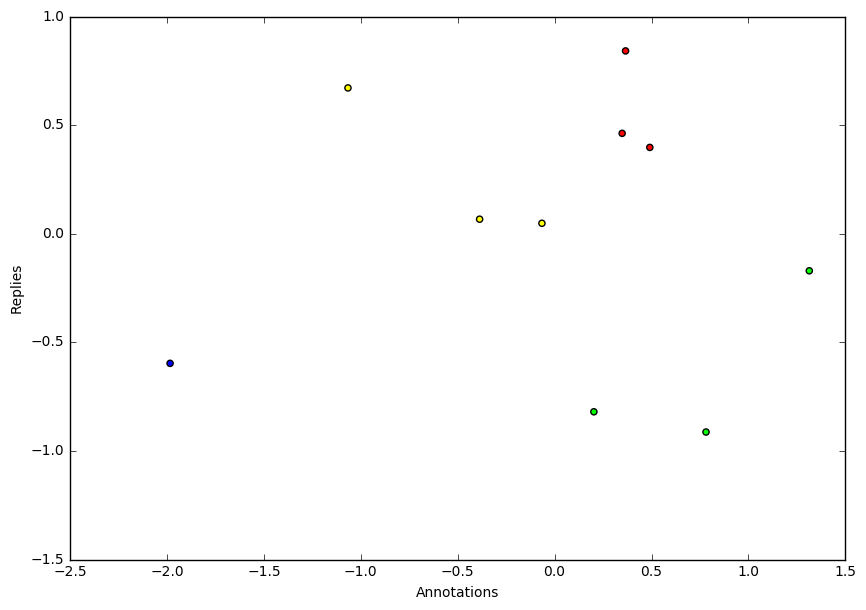

In [39]:
#kmeans = KMeans(n_clusters=3).fit(FebFM[['annotations','replies']])
colormap = np.array(['red','lime','blue','yellow'])
plt.figure(figsize=(10,7))
plt.ylabel('Replies')
plt.xlabel('Annotations')
#plt.scatter(FebFM['annotations'],FebFM['replies'],c=colormap[kmeans.labels_])
plt.scatter(reduced_data[:,0],reduced_data[:,1],c=colormap[kmeans.labels_])